<a href="https://colab.research.google.com/github/Adeyinka-hub/MY-MACHINE-LEARNING-AND-DEEP-LEARNING-WORKS-ON-KAGGLE-AND-ZINDI-RESPECTIVELY/blob/master/ZINDI_USAID's_Intelligent_Forecasting_Challenge_Model_Future_Contraceptive_Use.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
import calendar
import datetime
from dateutil.relativedelta import relativedelta
import category_encoders as ce
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [ ]:
trainb=pd.read_csv('/content/drive/My Drive/contraceptive_logistics_data.csv')

submission_usaid=pd.read_csv('/content/drive/My Drive/submission_format.csv')
sub_zindi=pd.read_csv('/content/drive/My Drive/SampleSubmission_usaid.csv')

contraceptive_case_data_monthly=pd.read_csv('/content/drive/My Drive/contraceptive_case_data_monthly.csv')

product=pd.read_csv('/content/drive/My Drive/product.csv')
service_delivery_site_data=pd.read_csv('/content/drive/My Drive/service_delivery_site_data.csv')
contraceptive_case_data_annual=pd.read_csv('/content/drive/My Drive/contraceptive_case_data_annual.csv')
trainb=trainb.merge(service_delivery_site_data[['site_code','site_type','site_latitude','site_longitude']],on='site_code')
trainb=trainb.merge(product[['product_code','product_type']],on='product_code')
trainb['ID']=trainb.year.astype(str)+' X '+trainb.month.astype(str)+' X '+trainb['site_code']+' X '+trainb['product_code']

In [ ]:
trainb.head()

,year,month,region,district,site_code,product_code,stock_initial,stock_received,stock_distributed,stock_adjustment,stock_end,average_monthly_consumption,stock_stockout_days,stock_ordered,site_type,site_latitude,site_longitude,product_type,ID
0,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,75,0,21,-54,0,18,0,100.0,Hospital,6.730937,-3.483863,Injectable Contraceptive,2019 X 1 X C4001 X AS27134
1,2019,2,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,0,0,0,0,0,18,0,100.0,Hospital,6.730937,-3.483863,Injectable Contraceptive,2019 X 2 X C4001 X AS27134
2,2019,3,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,0,100,0,0,100,7,0,0.0,Hospital,6.730937,-3.483863,Injectable Contraceptive,2019 X 3 X C4001 X AS27134
3,2019,4,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,100,0,2,0,98,1,0,0.0,Hospital,6.730937,-3.483863,Injectable Contraceptive,2019 X 4 X C4001 X AS27134
4,2019,5,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,98,0,31,0,67,11,0,0.0,Hospital,6.730937,-3.483863,Injectable Contraceptive,2019 X 5 X C4001 X AS27134


In [ ]:
trainb.isnull().sum()

year                             0
month                            0
region                           0
district                         0
site_code                        0
product_code                     0
stock_initial                    0
stock_received                   0
stock_distributed                0
stock_adjustment                 0
stock_end                        0
average_monthly_consumption      0
stock_stockout_days              0
stock_ordered                  770
site_type                        0
site_latitude                    0
site_longitude                   0
product_type                     0
ID                               0
dtype: int64

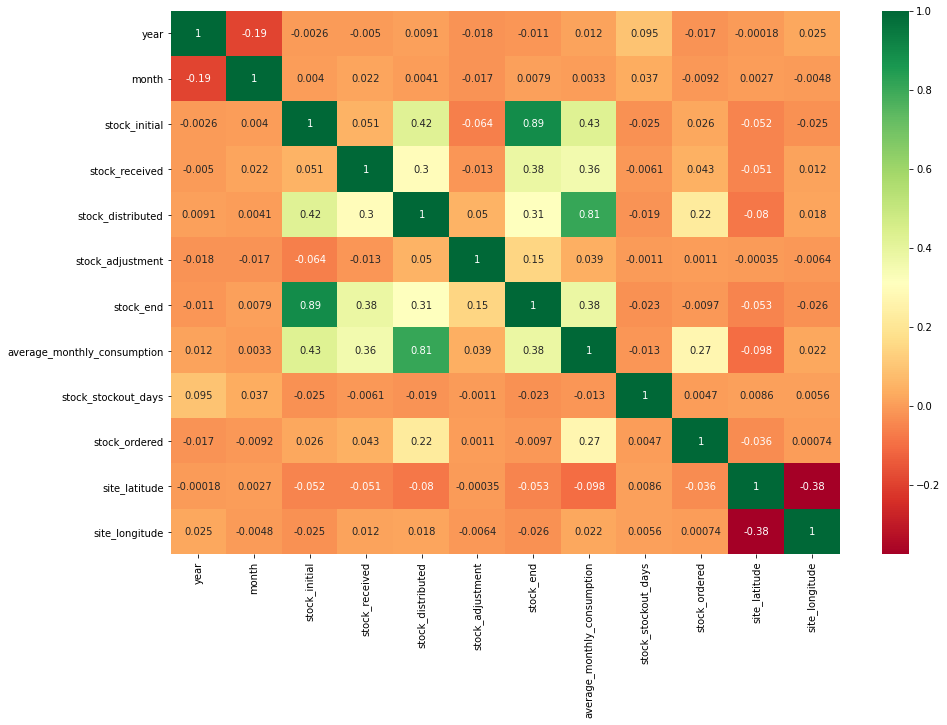

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
#get correlations of each features in dataset
corrmat = trainb.corr()
#top_corr_features = corrmat.index
plt.figure(figsize=(15,10))
#plot heat map
g=sns.heatmap(trainb.corr(),annot=True,cmap="RdYlGn")

In [ ]:
trainb['stock_ordered'].isnull().sum() 

770

In [ ]:
trainb = trainb.drop(['stock_ordered'], axis = 1)

In [ ]:
trainb.shape

(38842, 18)

In [ ]:
trainb=trainb.sort_values(by=['year','month'],ascending=True)
trainb['diff']=trainb.groupby(['site_code','product_code'])['stock_distributed'].diff()
trainb['diff']=trainb['diff'].fillna(0)
trainb['cumsum_diff']=trainb.groupby(['site_code','product_code'])['diff'].cumsum()

trainb['cumsum']=trainb.groupby(['site_code','product_code'])['stock_distributed'].cumsum()

In [ ]:
trainb.drop(['diff'],axis=1,inplace=True)

In [ ]:
trainb['shift_1']=trainb.groupby(['site_code','product_code'],sort=False)['stock_distributed'].shift(1)
trainb['shift_2']=trainb.groupby(['site_code','product_code'],sort=False)['stock_distributed'].shift(2)

trainb.loc[trainb['shift_1'].isnull(),'shift_1']=trainb.loc[trainb['shift_1'].isnull(),'average_monthly_consumption'].values
trainb.loc[trainb['shift_2'].isnull(),'shift_2']=trainb.loc[trainb['shift_2'].isnull(),'average_monthly_consumption'].values

trainb['stock_distributed_t1']=trainb.groupby(['site_code','product_code'],sort=False)['stock_distributed'].shift(-1)
trainb['stock_distributed_t2']=trainb.groupby(['site_code','product_code'],sort=False)['stock_distributed'].shift(-2)
trainb['stock_distributed_t3']=trainb.groupby(['site_code','product_code'],sort=False)['stock_distributed'].shift(-3)

trainb.loc[trainb['stock_distributed_t1'].isnull(),'stock_distributed_t1']=trainb.loc[trainb['stock_distributed_t1'].isnull(),'average_monthly_consumption'].values
trainb.loc[trainb['stock_distributed_t2'].isnull(),'stock_distributed_t2']=trainb.loc[trainb['stock_distributed_t2'].isnull(),'average_monthly_consumption'].values
trainb.loc[trainb['stock_distributed_t3'].isnull(),'stock_distributed_t3']=trainb.loc[trainb['stock_distributed_t3'].isnull(),'average_monthly_consumption'].values

trainb['rolling_mean']=trainb[['shift_1','shift_2','stock_distributed']].mean(axis=1)

In [ ]:
grp={'month,region,product_code':['stock_initial','stock_received','rolling_mean'],'month,district,product_code':['stock_initial','stock_received','rolling_mean'],
     'month,district,site_code,product_code':['stock_initial','stock_received','rolling_mean'],
     'month,region,product_type':['stock_initial','stock_received','rolling_mean',],'month,district,product_type':['stock_initial','stock_received','rolling_mean'],
     'month,district,site_code,product_type':['stock_initial','stock_received','rolling_mean'],
     'region,product_code':['stock_initial','stock_received','rolling_mean'],'district,product_code':['stock_initial','stock_received','rolling_mean'],
     'district,site_code,product_code':['stock_initial','stock_received','rolling_mean'],
     'region,product_type':['stock_initial','stock_received','rolling_mean'],'district,product_type':['stock_initial','stock_received','rolling_mean'],
     'district,site_code,product_type':['stock_initial','stock_received','rolling_mean']}

In [ ]:
for g in grp:
  dic={}
  for j in grp[g]:
    dic[j]=[np.mean,np.median,np.std]
  pp=trainb.groupby(g.split(',')).agg(dic).reset_index()
  pp.columns=[c[0] if c[1]=='' else g+'_'+c[0]+'_'+c[1] for c in pp.columns]
  trainb=trainb.merge(pp,on=g.split(','))

In [ ]:
trainb['calendar']=trainb[['year','month']].apply(lambda x:datetime.datetime(x['year'],x['month'],calendar.monthrange(x['year'],x['month'])[1]),axis=1)

In [ ]:
test=trainb.loc[trainb['calendar']<=datetime.datetime(2019,6,30)].sort_values(by=['year','month'],ascending=True).drop_duplicates(subset=['site_code','product_code'],keep='last')
train=trainb.loc[~trainb['ID'].isin(test['ID'].values)]
train=train.loc[train['calendar']<=datetime.datetime(2019,6,30)]

# Replacing Zeros in the target feature "stock_distributed" with NaN's and later delete all the rows containing Nan's in "stock_distributed" column.

In [ ]:
trainb['stock_distributed'] = trainb['stock_distributed'].replace(0, np.nan)
trainb = trainb.dropna(axis=0, subset=['stock_distributed']) 

# Filling up the missing values in "stock_ordered" using the most correlated features.

In [ ]:
#Get the index of missing so we can some of the values used for filling
missing_indx = list(trainb['stock_ordered'][trainb['stock_ordered'].isna()].index)

In [ ]:
# Explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Run imputer with a Random Forest estimator
imp = IterativeImputer(RandomForestRegressor(n_estimators=5), max_iter=5, random_state=1)

to_train = ['stock_ordered','stock_distributed', 'average_monthly_consumption']
trainb[to_train] = pd.DataFrame(imp.fit_transform(trainb[to_train]), columns=to_train)

In [ ]:
trainb['stock_distributed'][missing_indx].head(5)

In [ ]:
enc=ce.OneHotEncoder(cols=['region','district','product_code','site_type','product_type'],drop_invariant=True,use_cat_names=True)
d_train=enc.fit_transform(train)
d_test=enc.transform(test)
col=list(d_train.columns)

col.remove('site_code')
#col.remove('stock_ordered')
col.remove('stock_received')

col.remove('shift_2')
col.remove('calendar')

col.remove('stock_initial')
col.remove('stock_stockout_days')

col.remove('stock_distributed')
#col.remove('stock_distributed_t3')
col.remove('ID')

In [ ]:
model1=LGBMRegressor(num_leaves = 70, subsample=0.8, max_depth = 8,feature_fraction = 0.5,
                     colsample_bytree = 0.4,bagging_fraction=0.7,min_child_weight = 24,
                     min_split_gain = 0.063,learning_rate=0.008,n_estimators=1000,verbosity=1,
                     silent=None,objective='regression',booster='gbtree',n_jobs=-1,random_state=101)

model2=LGBMRegressor(num_leaves = 70, subsample=0.8, max_depth = 8,feature_fraction = 0.5,
                     colsample_bytree = 0.4,bagging_fraction=0.7,min_child_weight = 24,
                     min_split_gain = 0.063,learning_rate=0.008,n_estimators=1000,verbosity=1,
                     silent=None,objective='regression',booster='gbtree',n_jobs=-1,random_state=101)

model3=LGBMRegressor(num_leaves = 70, subsample=0.8, max_depth = 8,feature_fraction = 0.5,
                     colsample_bytree = 0.4,bagging_fraction=0.7,min_child_weight = 24,
                     min_split_gain = 0.063,learning_rate=0.008,n_estimators=1000,verbosity=1,
                     silent=None,objective='regression',booster='gbtree',n_jobs=-1,random_state=101)

In [ ]:
y1='stock_distributed_t1'
y2='stock_distributed_t2'
y3='stock_distributed_t3'

In [ ]:
d_test['predicted1']=0
d_test['predicted2']=0
d_test['predicted3']=0

In [ ]:
n_estimators = 2000
max_features= 2
min_samples_split= 5

In [ ]:
clf = ExtraTreesClassifier(n_estimators=n_estimators,
                           max_features= max_features,
                           criterion= 'entropy',
                           min_samples_split= min_samples_split,
                           max_depth= max_features,
                           min_samples_leaf= min_samples_split, ## the default is 1 (note we use more than one sample for the split)
                           class_weight='balanced_subsample',
                           verbose=1,random_state=12345)#depth10

cl={}
for y in [y1,y2,y3]:
  clf.fit(d_train[col].fillna(0), d_train[y])
  model = SelectFromModel(clf, prefit=True,threshold='median')
  cl[y]=list(np.array(col)[model.get_support()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   10.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   10.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   10.6s finished


In [ ]:
x_tr,y_tr=d_train.loc[d_train['calendar']<=datetime.datetime(2019,5,31),cl[y1]],d_train.loc[d_train['calendar']<=datetime.datetime(2019,5,31),y1]
model1.fit(x_tr,y_tr)
d_test['predicted1']=np.round(model1.predict(d_test[cl[y1]]))

In [ ]:
x_tr,y_tr=d_train.loc[d_train['calendar']<=datetime.datetime(2019,4,30),cl[y2]],d_train.loc[d_train['calendar']<=datetime.datetime(2019,4,30),y2]
model2.fit(x_tr,y_tr)
d_test['predicted2']=np.round(model2.predict(d_test[cl[y2]]))

In [ ]:
x_tr,y_tr=d_train.loc[d_train['calendar']<=datetime.datetime(2019,3,31),cl[y3]],d_train.loc[d_train['calendar']<=datetime.datetime(2019,3,31),y3]
model3.fit(x_tr,y_tr)
d_test['predicted3']=np.round(model3.predict(d_test[cl[y3]]))

In [ ]:
d_test['site_code']=d_test['ID'].str.split('X',expand=True)[2].str.strip()
d_test['product_code']=d_test['ID'].str.split('X',expand=True)[3].str.strip()
aux=d_test.sort_values(by=['year','month'])
aux.drop_duplicates(subset=['site_code','product_code'],keep='last',inplace=True)

aux['ID']=aux.year.astype(str)+' X '+'7'+' X '+aux['site_code']+' X '+aux['product_code']
a=pd.DataFrame({'ID':aux['ID'].values,'prediction':aux['predicted1'].values})

aux=d_test.sort_values(by=['year','month'])
aux.drop_duplicates(subset=['site_code','product_code'],keep='last',inplace=True)
aux['ID']=aux.year.astype(str)+' X '+'8'+' X '+aux['site_code']+' X '+aux['product_code']
b=pd.DataFrame({'ID':aux['ID'].values,'prediction':aux['predicted2'].values})

aux=d_test.sort_values(by=['year','month'])
aux.drop_duplicates(subset=['site_code','product_code'],keep='last',inplace=True)
aux['ID']=aux.year.astype(str)+' X '+'9'+' X '+aux['site_code']+' X '+aux['product_code']
c=pd.DataFrame({'ID':aux['ID'].values,'prediction':aux['predicted3'].values})

dd=pd.concat([a,b,c]).reset_index(drop=True)

In [ ]:
zindi_sub=trainb[['ID','stock_distributed']].merge(dd,on='ID',how='left')
zindi_sub=zindi_sub.loc[(zindi_sub['ID'].str.startswith('2019 X 7',na=False))|(zindi_sub['ID'].str.startswith('2019 X 8',na=False))|(zindi_sub['ID'].str.startswith('2019 X 9',na=False))]
zindi_sub.fillna(0,inplace=True)
zindi_sub.loc[zindi_sub['prediction']<0,'prediction']=-1*zindi_sub.loc[zindi_sub['prediction']<0,'prediction'].values
np.sqrt(mean_squared_error(zindi_sub['stock_distributed'],zindi_sub['prediction']))#24.349696859134774

26.47698193790788

In [ ]:
'stock_initial','average_monthly_consumption',

In [ ]:
trainb.corr().head(50)

,year,month,stock_initial,stock_received,stock_distributed,stock_adjustment,stock_end,average_monthly_consumption,stock_stockout_days,site_latitude,site_longitude,cumsum_diff,cumsum,shift_1,shift_2,stock_distributed_t1,stock_distributed_t2,stock_distributed_t3,rolling_mean,"month,region,product_code_stock_initial_mean","month,region,product_code_stock_initial_median","month,region,product_code_stock_initial_std","month,region,product_code_stock_received_mean","month,region,product_code_stock_received_median","month,region,product_code_stock_received_std","month,region,product_code_rolling_mean_mean","month,region,product_code_rolling_mean_median","month,region,product_code_rolling_mean_std","month,district,product_code_stock_initial_mean","month,district,product_code_stock_initial_median","month,district,product_code_stock_initial_std","month,district,product_code_stock_received_mean","month,district,product_code_stock_received_median","month,district,product_code_stock_received_std","month,district,product_code_rolling_mean_mean","month,district,product_code_rolling_mean_median","month,district,product_code_rolling_mean_std","month,district,site_code,product_code_stock_initial_mean","month,district,site_code,product_code_stock_initial_median","month,district,site_code,product_code_stock_initial_std",...,"district,product_code_stock_received_std","district,product_code_rolling_mean_mean","district,product_code_rolling_mean_median","district,product_code_rolling_mean_std","district,site_code,product_code_stock_initial_mean","district,site_code,product_code_stock_initial_median","district,site_code,product_code_stock_initial_std","district,site_code,product_code_stock_received_mean","district,site_code,product_code_stock_received_median","district,site_code,product_code_stock_received_std","district,site_code,product_code_rolling_mean_mean","district,site_code,product_code_rolling_mean_median","district,site_code,product_code_rolling_mean_std","region,product_type_stock_initial_mean","region,product_type_stock_initial_median","region,product_type_stock_initial_std","region,product_type_stock_received_mean","region,product_type_stock_received_median","region,product_type_stock_received_std","region,product_type_rolling_mean_mean","region,product_type_rolling_mean_median","region,product_type_rolling_mean_std","district,product_type_stock_initial_mean","district,product_type_stock_initial_median","district,product_type_stock_initial_std","district,product_type_stock_received_mean","district,product_type_stock_received_median","district,product_type_stock_received_std","district,product_type_rolling_mean_mean","district,product_type_rolling_mean_median","district,product_type_rolling_mean_std","district,site_code,product_type_stock_initial_mean","district,site_code,product_type_stock_initial_median","district,site_code,product_type_stock_initial_std","district,site_code,product_type_stock_received_mean","district,site_code,product_type_stock_received_median","district,site_code,product_type_stock_received_std","district,site_code,product_type_rolling_mean_mean","district,site_code,product_type_rolling_mean_median","district,site_code,product_type_rolling_mean_std"
year,1.000000,-0.203438,-0.023197,-0.024604,-0.037841,-0.034603,-0.032501,-0.028166,0.067173,0.033116,-0.009640,0.021523,0.230313,-0.018414,-0.017197,-0.012022,-0.006383,0.001930,-0.030091,-0.081726,-0.084517,-0.061654,-0.045954,-0.003896,-0.044717,-0.042597,-0.032848,-0.040507,-0.045648,-0.037364,-0.034751,-0.024910,-0.002580,-0.028084,-0.036066,-0.033920,-0.016478,-0.043565,-0.040213,-0.030165,...,-0.020506,-0.033564,-0.026759,-0.028084,-0.044377,-0.035401,-0.037460,-0.033678,-0.035524,-0.028739,-0.049421,-0.046298,-0.035516,-0.079050,-0.042854,-0.081149,-0.080996,NaN,-0.084169,-0.083339,-0.054242,-0.086209,-0.044334,-0.014380,-0.050679,-0.040282,0.000499,-0.048167,-0.053264,-0.034122,-0.059691,-0.045071,-0.029434,-0.048255,-0.050335,-0.019551,-0.048567,-0.067706,-0.059

In [ ]:
list(trainb.corr())

['year',
 'month',
 'stock_initial',
 'stock_received',
 'stock_distributed',
 'stock_adjustment',
 'stock_end',
 'average_monthly_consumption',
 'stock_stockout_days',
 'site_latitude',
 'site_longitude',
 'cumsum_diff',
 'cumsum',
 'shift_1',
 'shift_2',
 'stock_distributed_t1',
 'stock_distributed_t2',
 'stock_distributed_t3',
 'rolling_mean',
 'month,region,product_code_stock_initial_mean',
 'month,region,product_code_stock_initial_median',
 'month,region,product_code_stock_initial_std',
 'month,region,product_code_stock_received_mean',
 'month,region,product_code_stock_received_median',
 'month,region,product_code_stock_received_std',
 'month,region,product_code_rolling_mean_mean',
 'month,region,product_code_rolling_mean_median',
 'month,region,product_code_rolling_mean_std',
 'month,district,product_code_stock_initial_mean',
 'month,district,product_code_stock_initial_median',
 'month,district,product_code_stock_initial_std',
 'month,district,product_code_stock_received_mean',
 

In [ ]:
# 20.33, max_depth = 9(ExtraTreesClassifier), n_estimators = 1000, sub_sample = 0.8(LGBM)

In [ ]:
zindi_sub[['ID','prediction']].to_csv('LGBM1.csv',index=False)

In [ ]:
zindi_sub.head(30)

,ID,stock_distributed,prediction
23,2019 X 7 X C4001 X AS27134,13.0,13.0
27,2019 X 8 X C4001 X AS27134,7.0,7.0
31,2019 X 9 X C4001 X AS27134,9.0,8.0
53,2019 X 7 X C4001 X AS27133,88.0,85.0
56,2019 X 8 X C4001 X AS27133,25.0,26.0
80,2019 X 7 X C4023 X AS27133,50.0,49.0
82,2019 X 8 X C4023 X AS27133,50.0,49.0
84,2019 X 9 X C4023 X AS27133,75.0,73.0
109,2019 X 7 X C4056 X AS27134,4.0,4.0
113,2019 X 8 X C4056 X AS27134,8.0,9.0


In [ ]:
zindi_sub.shape

(1799, 3)

In [ ]:
#cat=pd.read_csv('usaid_baselinecat.csv')
#lgb=pd.read_csv('usaid_baseline1.csv')

In [ ]:
cat['prediction']=cat['prediction']*0.4 + lgb['prediction']*0.6

In [ ]:
#Ensemble
zindi_sub=trainb[['ID','stock_distributed']].merge(cat,on='ID',how='left')
zindi_sub=zindi_sub.loc[(zindi_sub['ID'].str.startswith('2019 X 7',na=False))|(zindi_sub['ID'].str.startswith('2019 X 8',na=False))|(zindi_sub['ID'].str.startswith('2019 X 9',na=False))]
zindi_sub.fillna(0,inplace=True)
zindi_sub.loc[zindi_sub['prediction']<0,'prediction']=-1*zindi_sub.loc[zindi_sub['prediction']<0,'prediction'].values
np.sqrt(mean_squared_error(zindi_sub['stock_distributed'],zindi_sub['prediction']))#36.97521765482335

In [ ]:
#zindi_sub[['ID','prediction']].to_csv(path_read+'DC1.csv',index=False)

In [ ]:
zindi_sub[['ID','prediction']].to_csv('DC1.csv',index=False)

In [ ]:
zindi_sub.head()

#Lgbm Bayesian Optimization:

In [ ]:
!pip install bayesian-optimization

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score,mean_squared_error
import warnings
warnings.filterwarnings('ignore')

X =d_train[col].fillna(0)
y = d_train[y]

In [ ]:
def bayesion_opt_lgbm(X, y, init_iter=3, n_iters=7, random_state=11, seed = 101, num_iterations = 100):
  dtrain = lgb.Dataset(data=X, label=y)
  def lgb_mean_squared_error(preds, dtrain):
      labels = dtrain.get_label()
      return 'mse', mean_squared_error(labels, preds), True
  # Objective Function
  def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, subsample,colsample_bytree,max_depth, min_split_gain, min_child_weight):
        
          params = {'application':'regression','num_iterations': num_iterations,
                    'learning_rate':0.008, 'early_stopping_round':50,
                    'metric':'lgb_mean_squared_error'} # Default parameters
          params["num_leaves"] = int(round(num_leaves))
          params['feature_fraction'] = max(min(feature_fraction, 1), 0)
          params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
          params['subsample'] = max(min(subsample, 1), 0)
          params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
          params['max_depth'] = int(round(max_depth))  
          params['min_split_gain'] = min_split_gain
          params['min_child_weight'] = min_child_weight
          cv_results = lgb.cv(params, dtrain, nfold=5, seed=seed,categorical_feature=[], stratified=False,
                              verbose_eval =None, feval=lgb_mean_squared_error)
          # print(cv_results)
          return np.max(cv_results['mse-mean'])
  # Domain space-- Range of hyperparameters 
  pds = {'num_leaves': (70, 75),
            'feature_fraction': (0.4, 0.5),
            'subsample': (0.7, 0.8),
            'colsample_bytree': (0.4, 0.6),
            'bagging_fraction': (0.6, 0.7),
            'max_depth': (8, 10),
            'min_split_gain': (0.05, 0.063),
            'min_child_weight': (22, 24)
            }

  # Surrogate model
  optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=random_state)
                                    
  # Optimize
  optimizer.maximize(init_points=init_iter, n_iter=n_iters)

bayesion_opt_lgbm(X, y, init_iter=5, n_iters=10, random_state=77, seed = 101, num_iterations = 1000)